### Install Pydicom to read X ray data

In [2]:
!pip install pydicom

     |████████████████████████████████| 1.9MB 10.1MB/s 


### Import required Libraries

In [3]:
import math
import os
import shutil
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import pydicom
import cv2
from sklearn.model_selection import train_test_split
from tqdm import tqdm

random_stat = 123
np.random.seed(random_stat)

### Mount google drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
os.chdir("/content/drive/MyDrive/Kaggle-Data")

### Download Darknet repository and make it ready to use

In [ ]:
!git clone https://github.com/AlexeyAB/darknet.git

# Build gpu version darknet
!cd darknet && sed '1 s/^.*$/GPU=1/; 2 s/^.*$/CUDNN=1/' -i Makefile

# -j <The # of cpu cores to use>. Chang 999 to fit your environment. Actually i used '-j 50'.
!cd darknet && make -j 999 -s
!cp darknet/darknet darknet_gpu

### Define and make required directories

In [6]:
DATA_DIR = "."


train_dcm_dir = os.path.join(DATA_DIR, "stage_2_train_images")
test_dcm_dir = os.path.join(DATA_DIR, "stage_2_test_images")

img_dir = os.path.join(os.getcwd(), "images")  # .jpg
label_dir = os.path.join(os.getcwd(), "labels")  # .txt
metadata_dir = os.path.join(os.getcwd(), "metadata") # .txt

# YOLOv3 config file directory
cfg_dir = os.path.join(os.getcwd(), "cfg")
# YOLOv3 training checkpoints will be saved here
backup_dir = os.path.join(os.getcwd(), "backup")

In [ ]:
for directory in [img_dir, label_dir, metadata_dir, cfg_dir, backup_dir]:
    if os.path.isdir(directory):
        continue
    os.mkdir(directory)

In [ ]:
!ls -shtl

total 970M
4.0K drwx------  2 root root 4.0K Nov 28 15:46 images
4.0K drwx------  2 root root 4.0K Nov 28 15:46 labels
4.0K drwx------  2 root root 4.0K Nov 28 15:42 cfg
   0 -rw-------  1 root root    0 Nov 28 15:40 train_log.txt
1.9M -rwx------  1 root root 1.9M Nov 28 14:55 darknet_gpu
4.0K drwx------ 13 root root 4.0K Nov 28 14:55 darknet
 85K -rw-------  1 root root  85K Nov 28 14:38 bad.list
247M -rw-------  1 root root 247M Nov 28 08:58 yolov4.h5
246M -rw-------  1 root root 246M Nov 28 08:57 yolov4.weights
205K -rw-------  1 root root 205K Nov 28 04:57 test.jpg
4.0K drwx------  2 root root 4.0K Nov 27 17:29 working
4.0K drwx------  2 root root 4.0K Nov 27 15:30 backup
4.0K drwx------  2 root root 4.0K Nov 27 15:30 metadata
4.0K drwx------  2 root root 4.0K Nov 22 05:01 stage_2_train_images
163M -rw-------  1 root root 163M Apr 27  2020 yolov4.conv.137
1.5M -rw-------  1 root root 1.5M Dec 11  2019 stage_2_train_labels.csv
1.6M -rw-------  1 root root 1.6M Dec 11  2019 stage_2_d

#### Check Annotations Available

In [7]:
annots = pd.read_csv(os.path.join(DATA_DIR, "stage_2_train_labels.csv"))
annots.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


### Utility Function to save images

In [8]:
def save_img_from_dcm(dcm_dir, img_dir, patient_id):
    img_fp = os.path.join(img_dir, "{}.jpg".format(patient_id))
    if os.path.exists(img_fp):
        return
    dcm_fp = os.path.join(dcm_dir, "{}.dcm".format(patient_id))
    img_1ch = pydicom.read_file(dcm_fp).pixel_array
    img_3ch = np.stack([img_1ch]*3, -1)

    img_fp = os.path.join(img_dir, "{}.jpg".format(patient_id))
    cv2.imwrite(img_fp, img_3ch)
    
def save_label_from_dcm(label_dir, patient_id, row=None):
    # rsna defualt image size
    img_size = 1024
    label_fp = os.path.join(label_dir, "{}.txt".format(patient_id))
    
    f = open(label_fp, "a")
    if row is None:
        f.close()
        return

    top_left_x = row[1]
    top_left_y = row[2]
    w = row[3]
    h = row[4]
    
    # 'r' means relative. 'c' means center.
    rx = top_left_x/img_size
    ry = top_left_y/img_size
    rw = w/img_size
    rh = h/img_size
    rcx = rx+rw/2
    rcy = ry+rh/2
    
    line = "{} {} {} {} {}\n".format(0, rcx, rcy, rw, rh)
    
    f.write(line)
    f.close()
        
def save_yolov3_data_from_rsna(dcm_dir, img_dir, label_dir, annots):
    for row in tqdm(annots.values):
        patient_id = row[0]

        img_fp = os.path.join(img_dir, "{}.jpg".format(patient_id))
        if os.path.exists(img_fp):
            save_label_from_dcm(label_dir, patient_id, row)
            continue

        target = row[5]
        # Since kaggle kernel have samll volume (5GB ?), I didn't contain files with no bbox here.
        if target == 0:
            continue
        save_label_from_dcm(label_dir, patient_id, row)
        save_img_from_dcm(dcm_dir, img_dir, patient_id)

### Save Images


In [ ]:
save_yolov3_data_from_rsna(train_dcm_dir, img_dir, label_dir, annots)

100%|██████████| 30227/30227 [1:10:59<00:00,  7.10it/s]


### Plot one of the positive images

0 0.36181640625 0.33349609375 0.2080078125 0.3701171875

0 0.673828125 0.36962890625 0.25 0.4423828125



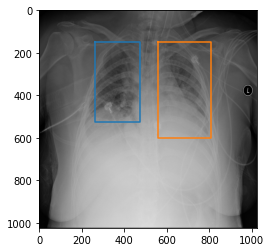

In [ ]:
ex_patient_id = annots[annots.Target == 1].patientId.values[0]
ex_img_path = os.path.join(img_dir, "{}.jpg".format(ex_patient_id))
ex_label_path = os.path.join(label_dir, "{}.txt".format(ex_patient_id))
#print(ex_img_path)
plt.imshow(cv2.imread(ex_img_path))

img_size = 1014
with open(ex_label_path, "r") as f:
    for line in f:
        print(line)
        class_id, rcx, rcy, rw, rh = list(map(float, line.strip().split()))
        x = (rcx-rw/2)*img_size
        y = (rcy-rh/2)*img_size
        w = rw*img_size
        h = rh*img_size
        plt.plot([x, x, x+w, x+w, x], [y, y+h, y+h, y, y])

### Create text files required for model training

In [ ]:
def write_train_list(metadata_dir, img_dir, name, series):
    list_fp = os.path.join(metadata_dir, name)
    with open(list_fp, "w") as f:
        for patient_id in series:
            line = "{}\n".format(os.path.join(img_dir, "{}.jpg".format(patient_id)))
            f.write(line)

In [ ]:
# Following lines do not contain data with no bbox
patient_id_series = annots[annots.Target == 1].patientId.drop_duplicates()

tr_series, val_series = train_test_split(patient_id_series, test_size=0.1, random_state=random_stat)
print("The # of train set: {}, The # of validation set: {}".format(tr_series.shape[0], val_series.shape[0]))

# train image path list
write_train_list(metadata_dir, img_dir, "tr_list.txt", tr_series)
# validation image path list
write_train_list(metadata_dir, img_dir, "val_list.txt", val_series)

The # of train set: 5410, The # of validation set: 602


In [ ]:
data_extention_file_path = os.path.join(cfg_dir, 'rsna.data')
with open(data_extention_file_path, 'w') as f:
    contents = """classes= 1
train  = {}
valid  = {}
names  = {}
backup = {}
    """.format(os.path.join(metadata_dir, "tr_list.txt"),
               os.path.join(metadata_dir, "val_list.txt"),
               os.path.join(cfg_dir, 'rsna.names'),
               backup_dir)
    f.write(contents)

In [ ]:
!cat cfg/rsna.data

classes= 1
train  = /content/drive/My Drive/Kaggle-Data/metadata/tr_list.txt
valid  = /content/drive/My Drive/Kaggle-Data/metadata/val_list.txt
names  = /content/drive/My Drive/Kaggle-Data/cfg/rsna.names
backup = /content/drive/My Drive/Kaggle-Data/backup
    

### Configuration changes 

In [ ]:
!echo "pneumonia" > cfg/rsna.names

### Download pretrained weights

In [ ]:
!wget -q https://pjreddie.com/media/files/darknet53.conv.74

In [ ]:
!chmod 755 darknet_gpu
#!chmod -R 644 darknet/
!chmod 755 darknet53.conv.74 

In [ ]:
!ls -ltr

total 834052
-rwx------  1 root root 162482580 Mar 25  2018 darknet53.conv.74
-rw-------  1 root root   1647396 Dec 11  2019 stage_2_detailed_class_info.csv
-rw-------  1 root root   1490034 Dec 11  2019 stage_2_train_labels.csv
-rw-------  1 root root 170038676 Apr 27  2020 yolov4.conv.137
drwx------  2 root root      4096 Nov 22 05:01 stage_2_train_images
drwx------  2 root root      4096 Nov 27 15:30 metadata
drwx------  2 root root      4096 Nov 27 15:30 labels
drwx------  2 root root      4096 Nov 27 15:30 images
drwx------  2 root root      4096 Nov 27 15:30 cfg
drwx------  2 root root      4096 Nov 27 15:30 backup
drwx------  2 root root      4096 Nov 27 17:29 working
-rw-------  1 root root         0 Nov 28 04:54 train_log.txt
-rw-------  1 root root    209495 Nov 28 04:57 test.jpg
-rw-------  1 root root 257717640 Nov 28 08:57 yolov4.weights
-rw-------  1 root root 258390436 Nov 28 08:58 yolov4.h5
-rw-------  1 root root     86772 Nov 28 14:38 bad.list
drwx------ 13 root root 

### Run training iterator for 15300 iterations

In [ ]:
!./darknet_gpu detector train cfg/rsna.data cfg/rsna_yolov3.cfg_train darknet53.conv.74 -i 0 -dont_show -map

Streaming output truncated to the last 5000 lines.
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.356072, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.201808, Class: 0.477893, Obj: 0.172398, No Obj: 0.207994, .5R: 0.200000, .75R: 0.000000,  count: 5
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.108612, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.245938, Class: 0.253586, Obj: 0.262094, No Obj: 0.352137, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: 0.147952, Class: 0.266727, Obj: 0.157251, No Obj: 0.207869, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.109664, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.352825, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.317643, Class: 0.297931, Obj: 0.189695, No Obj: 0.207147, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.108538,

In [38]:
!ls -alsth backup

total 2.6G
235M -rw------- 1 root root 235M Nov 28 19:55 rsna_yolov3.backup
235M -rw------- 1 root root 235M Nov 28 19:02 rsna_yolov3_900.weights
235M -rw------- 1 root root 235M Nov 28 18:55 rsna_yolov3_800.weights
235M -rw------- 1 root root 235M Nov 28 18:48 rsna_yolov3_700.weights
235M -rw------- 1 root root 235M Nov 28 18:42 rsna_yolov3_600.weights
235M -rw------- 1 root root 235M Nov 28 18:35 rsna_yolov3_500.weights
235M -rw------- 1 root root 235M Nov 28 18:27 rsna_yolov3_400.weights
235M -rw------- 1 root root 235M Nov 28 18:20 rsna_yolov3_300.weights
235M -rw------- 1 root root 235M Nov 28 18:13 rsna_yolov3_200.weights
235M -rw------- 1 root root 235M Nov 28 18:06 rsna_yolov3_100.weights
235M -rw------- 1 root root 235M Nov 28 04:59 rsna_yolov3_15300.weights


### For testing set test configuration 

In [40]:
!chmod -R 755 darknet/
!chmod +x darknet_gpu

### Create test configuration rsna_yolov3.cfg_test from train copy. Just set -
#####batch=1
#####subdivisions=1

### Run trained model with weights on one of the validation image

In [27]:
!cd darknet && ./darknet detector test ../cfg/rsna.data ../cfg/rsna_yolov3.cfg_test ../backup/rsna_yolov3_15300.weights ../images/d373b335-d9d9-4594-b97e-03ec9aa8daa2.jpg -thresh 0.005

layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   608 x 608 x   3   ->   608 x 608 x  32  0.639 BFLOPs
    1 conv     64  3 x 3 / 2   608 x 608 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    2 conv     32  1 x 1 / 1   304 x 304 x  64   ->   304 x 304 x  32  0.379 BFLOPs
    3 conv     64  3 x 3 / 1   304 x 304 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    4 res    1                 304 x 304 x  64   ->   304 x 304 x  64
    5 conv    128  3 x 3 / 2   304 x 304 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    6 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
    7 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    8 res    5                 152 x 152 x 128   ->   152 x 152 x 128
    9 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
   10 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
   11 res    8                 152 x 

### Visualise Results
##### Above results predicted 5 bounding boxes

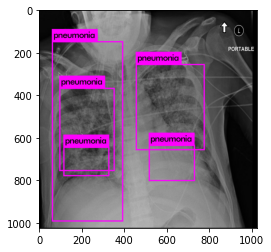

In [28]:
plt.imshow(cv2.imread("./darknet/predictions.jpg"))

### Check one more validation image

In [36]:
!cd darknet && ./darknet detector test ../cfg/rsna.data ../cfg/rsna_yolov3.cfg_test ../backup/rsna_yolov3_15300.weights ../images/ec910555-f698-4536-aff7-7fa9d3405d60.jpg -thresh 0.005

layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   608 x 608 x   3   ->   608 x 608 x  32  0.639 BFLOPs
    1 conv     64  3 x 3 / 2   608 x 608 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    2 conv     32  1 x 1 / 1   304 x 304 x  64   ->   304 x 304 x  32  0.379 BFLOPs
    3 conv     64  3 x 3 / 1   304 x 304 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    4 res    1                 304 x 304 x  64   ->   304 x 304 x  64
    5 conv    128  3 x 3 / 2   304 x 304 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    6 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
    7 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    8 res    5                 152 x 152 x 128   ->   152 x 152 x 128
    9 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
   10 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
   11 res    8                 152 x 

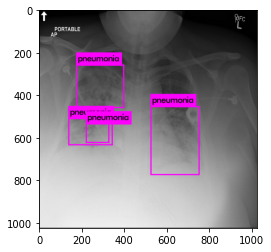

In [37]:
plt.imshow(cv2.imread("./darknet/predictions.jpg"))

In [42]:
!mv labels/*.txt images/

### Lets calculate Mean avarage precision

In [43]:
!cd darknet && ./darknet detector map ../cfg/rsna.data ../cfg/rsna_yolov3.cfg_train ../backup/rsna_yolov3_15300.weights -gpus 0


 CUDA-version: 10010 (10010), cuDNN: 7.6.5, GPU count: 1  
 OpenCV isn't used - data augmentation will be slow 
0
 0 : compute_capability = 750, cudnn_half = 0, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 18, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 1    608 x 608 x   3 ->  608 x 608 x  32 0.639 BF
   1 conv     64       3 x 3/ 2    608 x 608 x  32 ->  304 x 304 x  64 3.407 BF
   2 conv     32       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  32 0.379 BF
   3 conv     64       3 x 3/ 1    304 x 304 x  32 ->  304 x 304 x  64 3.407 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 304 x 304 x  64 0.006 BF
   5 conv    128       3 x 3/ 2    304 x 304 x  64 ->  152 x 152 x 128 3.407 BF
   6 conv     64       1 x 1/ 1    152 x 152 x 128 ->  152 x 152 x  64 0.379 BF
   7 conv    128       3 x 3/ 1    152 x 152 x  64 ->  152 x 152 x 128 3.407 BF
   8 Shortcut Layer: 5,  wt = 0, wn = 0,

### Mean average precision (mAP@0.50) = 0.851040